## Requirements 
* (done) Apply **mini-batch gradient descent** with appropriate batch size
* (done) Use appropriate **learning rate** (can be adaptive per epoch)
* (todo) Apply **dropout** - find appropriate dropout rate at each layer
* (done) Initialize random **weights** properly before training
* (done) Do basic image **augmentation** of training data using Keras
* (todo -- currently only 2 layers after input) Use **3 or more layers** with appropriate **number of neurons** per layer
* (done) Use **relu activation layer** in the right places
* (done) **Normalize and scale** the input before training with Keras
* (todo) Include **metrics**: testing, training accuracy validation curves and confusion matrix
* (todo) Display top common errors

In [479]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

In [480]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

## Load dataset

In [481]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [482]:
x_train.shape

(60000, 28, 28)

In [483]:
x_test.shape

(10000, 28, 28)

In [484]:
x_train = x_train[0:2000]
y_train = y_train[0:2000]

In [504]:
g = plt.imshow(x_train[3][:,:])

IndexError: too many indices for array

## Training dataset augmentation

Using Keras Datagen

In [486]:
x_train_augmented = x_train[0:500]
y_train_augmented = y_train[0:500]

In [487]:
x_train_augmented = x_train_augmented.reshape(-1,28,28,1)

In [488]:
x_train_augmented.shape

(500, 28, 28, 1)

In [489]:
# Augment 1k training dataset images
# Reference: https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train_augmented)

In [490]:
# Use datagen.flow to obtain the entire batch at once and prepend to original dataset.
x_train2 = None
for x_batch, y_batch in datagen.flow(x_train_augmented, y_train_augmented, batch_size=len(x_train_augmented)):
    x_train2 = x_batch
    break

In [491]:
# Re-shape the augmented dataset into (num_instances, width, height)
x_train_augmented = x_train2.reshape(len(x_train_augmented), 28, 28)

In [492]:
x_train[0:500] = x_train_augmented

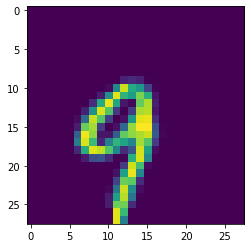

In [503]:
g = plt.imshow(x_train_augmented[3][:,:])

#### The above two images look the same..

In [494]:
np.array_equal(x_train_augmented[5], x_train[5])

False

#### Looks like Keras datagen actually did some augmentation. Not enough to be visible

## Scaling and Normalization
The training data is 1 3D array of (digit_label, pixel width, pixel height). For our MLP to run gradient descent, the width and height must be converted into a vector of 784 pixels.

This is accomplished using numpy's reshape() function.

In [497]:
num_pixels = x_train.shape[1] * x_train.shape[2]

# Scale input (examples, width, height) --> (examples, width*height)
x_train = x_train.reshape((x_train.shape[0], num_pixels)).astype('float32')
x_test = x_test.reshape((x_test.shape[0], num_pixels))

In [498]:
# Normalize pixel values from 0-255 to 0-1
x_train = x_train / 255
x_test = x_test / 255

## One hot encode the labels

One hot encoding essentially transforms the categorical values into a matrix where their existence or absence is marked by 1 or 0, respectively.

In [499]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

## Training functions

* Relu
* Mini-batch gradient descent based train()

In [500]:
def relu(x):
    return (x >= 0) * x

def relu2deriv(output):
    return output >= 0

In [501]:
'''
Runs a 3 layer mini batch gradient descent 

@ params: images
@ retval: void
''' 
def train(images, labels, test_images, test_labels):
    batch_size = 100

    alpha, iterations = (0.001, 300)
    
    # MNIST dataset specific settings and hidden layer neuron size
    pixels_per_image, num_labels, hidden_size = (784, 10, 100)

    # Weight initialization for various layers -- # of neurons based on the tuple passed to np.random
    weights_0_1 = 0.2 * np.random.random((pixels_per_image, hidden_size)) - 0.1
    #weights_1_2 = 0.2 * np.random.random((hidden_size, hidden_size//2)) - 0.1
    weights_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1
    
    for j in range(iterations):
        error, correct_cnt = (0.0, 0)
      
        for i in range(int(len(images) / batch_size)):
            batch_start, batch_end = ((i * batch_size), ((i+1) * batch_size))

            layer_0 = images[batch_start:batch_end]
            layer_1 = relu(np.dot(layer_0, weights_0_1))
            dropout_mask = np.random.randint(2, size=layer_1.shape)
            layer_1 *= dropout_mask * 2
            layer_2 = np.dot(layer_1, weights_1_2)

            error += np.sum((labels[batch_start:batch_end] - layer_2) ** 2)
            for k in range(batch_size):
                correct_cnt += int(np.argmax(layer_2[k:k+1])) == np.argmax(labels[batch_start+k:batch_start+k+1])

                layer_2_delta = (labels[batch_start:batch_end] - layer_2) / batch_size
                layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)
                layer_1_delta *= dropout_mask

                weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
                weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)

        if(j%10 == 0):
            test_error = 0.0
            test_correct_cnt = 0

            for i in range(len(test_images)):
                layer_0 = test_images[i:i+1]
                layer_1 = relu(np.dot(layer_0,weights_0_1))
                layer_2 = np.dot(layer_1, weights_1_2)

                test_error += np.sum((test_labels[i:i+1] - layer_2) ** 2)
                test_correct_cnt += int(np.argmax(layer_2) == \
                                         np.argmax(test_labels[i:i+1]))

            sys.stdout.write("\n" + \
            "I:" + str(j) + \
            " Test-Err:" + str(test_error/ float(len(test_images)))[0:5] +\
            " Test-Acc:" + str(test_correct_cnt/ float(len(test_images)))+\
            " Train-Err:" + str(error/ float(len(images)))[0:5] +\
            " Train-Acc:" + str(correct_cnt/ float(len(images))))


In [502]:
train(x_train, y_train, x_test, y_test)


I:0 Test-Err:0.742 Test-Acc:0.546 Train-Err:1.139 Train-Acc:0.1995
I:10 Test-Err:0.553 Test-Acc:0.7794 Train-Err:0.709 Train-Acc:0.5325
I:20 Test-Err:0.501 Test-Acc:0.7923 Train-Err:0.670 Train-Acc:0.5715
I:30 Test-Err:0.467 Test-Acc:0.8054 Train-Err:0.645 Train-Acc:0.5745
I:40 Test-Err:0.445 Test-Acc:0.807 Train-Err:0.619 Train-Acc:0.614
I:50 Test-Err:0.443 Test-Acc:0.8168 Train-Err:0.627 Train-Acc:0.6085
I:60 Test-Err:0.443 Test-Acc:0.8153 Train-Err:0.622 Train-Acc:0.604
I:70 Test-Err:0.432 Test-Acc:0.8126 Train-Err:0.617 Train-Acc:0.601
I:80 Test-Err:0.436 Test-Acc:0.8113 Train-Err:0.617 Train-Acc:0.605
I:90 Test-Err:0.430 Test-Acc:0.8091 Train-Err:0.611 Train-Acc:0.608
I:100 Test-Err:0.435 Test-Acc:0.8126 Train-Err:0.611 Train-Acc:0.6055
I:110 Test-Err:0.431 Test-Acc:0.8089 Train-Err:0.598 Train-Acc:0.6085
I:120 Test-Err:0.425 Test-Acc:0.8158 Train-Err:0.601 Train-Acc:0.6155
I:130 Test-Err:0.428 Test-Acc:0.8161 Train-Err:0.607 Train-Acc:0.6115
I:140 Test-Err:0.421 Test-Acc:0.8172 

## Metrics

### Training

### Testing

### Confusion matrix

### Most common errors